<a href="https://colab.research.google.com/github/tirals88/Deep-Learning-from-Scratch/blob/main/1%EA%B6%8C_5%EC%9E%A5_(1)_%EC%98%A4%EC%B0%A8%EC%97%AD%EC%A0%84%ED%8C%8C%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#드라이브연동
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch05'

/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch05


In [3]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 오차역전파법

앞 장에서는 신경망 학습에 대해서 설명을 하였다. 그 때는 가중치 매개변수의 손실함수의 기울기를 수치 미분을 사용하여 구하였다.
수치미분은 구현이 쉽고 단순하지만 오래걸린다는 단점이 있었다. 이번에는 효율적으로 계산하는 '오차역전파법'을 배워볼 것이다.

먼저 시작적 ( 계산 그래프를 통하여 )으로 이해를 해보자.

오차역전파법을 계산 그래프로 설명한다는 생각은 **Andrej Karpathy**의 블로그, **Fei-Fei Li** 교수가 진행한 스탠퍼드 대학교의 딥러닝 수업 CS231n을 참고하였다고한다.
물론 내가 정리한 모든 내용들 또한 **밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch)**의 내용들이다.

## 계산그래프

그림을 통한 이해는 책을 통해 복습
https://github.com/WegraLee/deep-learning-from-scratch/tree/master/ch05



계산 그래프의 특징은 '국소적 계산'을 전파함으로써 최종 결과를 얻는다는 점에 있다.

국소적 계산은 결국 전체에서 어떤 일이 벌어지든 상관없이 독립적으로 자신과 관계된 정보만으로 결과를 출력할 수 있다는 것이다.

👉 각 노드는 자신과 관련된 계산 외에는 아무것도 신경 쓸 게 없다.

국소적 계산의 장점
1. 전체가 아무리 복잡하더라도 각 노드에서는 단순한 계산에 집중하여 문제를 단순화 할 수 있다.
2. 중간 계산 결과를 모두 보관할 수 있다.
3. **역전파를 통해 '미분'을 효율적으로 계산할 수 있다.**



## 연쇄법칙

합성함수
- 여러 함수로 굿어된 함수이다.
$z = (x + y)^2$, 이 식은 아래의 두 개의 식으로 구성된 것이다.
$$z = t^2$$
$$t = x + y$$

- 합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타내진다.
$$\frac{\partial z}{\partial x} = \frac{∂z}{∂t}\frac{∂t}{∂x}$$

위 식에서 $∂t$는 서로 지울 수 있다.

$$\frac{∂z}{∂t} = 2t$$

$$\frac{∂t}{∂x} = 1$$

$$\frac{\partial z}{\partial x} = \frac{∂z}{∂t}\frac{∂t}{∂x} = 2t ⋅1 = 2(x+y)$$

- 국소적 미분의 전달

$→ \frac{\partial z}{\partial z}$ 

$→ \frac{∂z}{∂z}\frac{∂z}{∂t}$ 

$→ \frac{\partial z}{\partial z}\frac{∂z}{∂t}\frac{∂t}{∂x}$

이는 결국 $x$에 대한 $z$의 미분이 된다.

## 덧셈 노드의 역전파

$z = x + y$에서 $\frac{∂z}{∂x} = 1$, $\frac{∂z}{∂y} = 1$이 된다.

그러므로 덧셈 노드에서 역전파는 상류에서 전해진 미분 ( $\frac{∂L}{∂z}$에 1을 곱하여 하류로 흘려보내는 것이다. 즉 1을 곱하기만 할 분이므로 입력된 값을 그대로 다음 노드로 흘려보내게 된다.

덧셈 노드 역전파는 입력 신호를 다음 노드로 출력할 뿐이므로 그대로 다음 노드로 전달한다.

## 곱셈 노드의 역전파

$z = x ⋅ y$에서 $\frac{∂z}{∂x} = y$, $\frac{∂z}{∂y} = x$가 된다.

곱셈 노드 역전파는 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보낸다.

**덧셈의 역전파는 상류의 값을 그대로 흘려보내기 대문에 순방향 입력 신호의 값은 필요하지 않았지만,**

**곱셈의 역전파는 순방향 입력 신호의 값이 필요하다. 그래서 곱셈 노드를 구현할 때는 순전파의 입력 신호를 변수에 저장해둔다.**

# 단순 계층 구현

- 곱셈 노드 : MulLayer

- 덧셈 노드 : AddLayer

- 계층 : 신경망의 기능 단위. / 예를 들어 시그모이드 함수를 위한 Sigmoid, 행렬 곱을 위한 Affine 등이 해당 됨

## 곱셈 계층

모든 계층은 forward() / backward() 공통의 메서드(인터페이스)를 갖도록 구현할 것이다.

In [5]:
# 곱셈 계층 

class MulLayer():
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y

    return out

  def backward(self, dout):
    dx = dout * self.y # x 와 y 를 바꿔 곱한다
    dy = dout * self.x

    return dx, dy

In [6]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price) # 220

220.00000000000003


In [7]:
# 역전파

dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


## 덧셈 계층

곱셈과 같이 forward() / backward() 구분

In [8]:
class AddLayer():
  def __init__(self):
    pass
  
  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

# 활성화 함수 계층 구현

- Relu

- Sigmoid

## Relu 계층

활성화 함수로 사용되는 ReLU의 수식은 다음과 같다.

$$y = \begin{cases}x  (x > 0)\\0  (x\leq0)\end{cases}$$


위 식에서 $x$ 에 대한 $y$ 의 미분은 아래와 같다.

$$ \frac{\partial y}{\partial x} = \begin{cases}1 (x > 0)\\0 (x\leq0)\end{cases}$$

위와 같이 순전파 때의 입력인 x가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘린다.

반면, 순전파 때 $x$가 0 이하면 역전파 때는 하류로 신호를 보내지 않는다. ( 0을 보낸다 )

In [9]:
#ReLU 계층 구현

class ReLU:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = ( x <= 0 ) # 0 보다 작은 원소들의 인수들을 True
    out = x.copy()
    out[self.mask] = 0  # 0 보다 작은 원소들 0으로 치환

    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

## Sigmoid 계층

시그모이드 함수는 다음과 같다.
$$y = \frac{1}{1+\exp(-x)}$$

시그모이드 계층의 계산 그래프는 다음과 같다.
1. $x$ / $-1$ 의 곱셈 계층 : $-x$
2. $-x$ 의 exp 계층 : exp($-x$)
3. exp($-x$)와 1의 더하기 계층 : 1 + exp($-x$)
4. 1 + exp($-x$)의 나누기 계층 : $\frac{1}{1+\exp(-x)}$

- 1단계 '/' 노드, $y = \frac{1}{x}$ 을 미분하면 다음 식이 된다.

$$\frac{\partial y}{\partial x} = -\frac{1}{x^2} = -y^2$$

위 식에 따라 역전파 때는 상류에서 흘러온 값에 $-y^2$ (순전파의 출력을 제곱한 후 마이너스를 붙인 값)을 곱해서 하류로 전달한다.

$$\frac{\partial L}{\partial y} → -\frac{\partial L}{\partial y}y^2$$

- 2단계 '+' 노드, 상류의 값을 그대로 하류로 흘려보낸다. 

- 3단계 '$\exp$'노드, $y = \exp(x)$ 연산을 수행하며, 그 미분은 다음과 같다.

$$\frac{\partial y}{\partial x} = \exp(x)$$

위 식에 따라 역전파 때는 상류에서 흘러온 값에 순전파의 출력 ($\exp(-x)$)을 곱하여 하류로 흘려보낸다.

$$-\frac{\partial L}{\partial y}y^2 →-\frac{\partial L}{\partial y}y^2\exp(-x) $$

- 4단계 'x' 노드, 순전파 때의 값을 '서로 바꿔' 곱하여 내보낸다.

이 예에서는 '-1'을 곱한다.

결국 최종 출력 값으로 $\frac{\partial L}{\partial y}y^2\exp(-x)$이 된다.

- Sigmoid 계층의 계산 그래프 ( 간소화 버전 )

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%205-21.png?raw=true">

<출처 : " https://github.com/WegraLee/deep-learning-from-scratch.git ">

위와 같이 간소화 버전은 중간 계산들을 생략할 수 있어서 더 효율적인 계산이라 할 수 있다.

또한 $\frac{\partial L}{\partial y}y^2\exp(-x)$는 다음처럼 정리해서 쓸 수도 있다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/e%205.12.png?raw=true">

위와 같이 Sigmoid 계층의 역전파는 순전파의 출력 ($y$)만으로 계산이 가능하다.

In [10]:
# Sigmoid 계층 구현

class Sigmoid:
  def __init__(self):
    self.out = None
  
  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx
  
# 순전파의 출력을 인스턴스 변수 out에 보관했다가, 역전파 계산 때 그 값을 사용한다.

# Affine / Softmax 계층 구현

## Affine 계층

신경망의 순전파에서는 가중치 신호의 총합을 계산하기 때문에 행렬의 곱을 사용하였다.

```
X = np.random.rand(2)    # 입력
W = np.random.rand(2, 3) # 가중치
B = np.random.rand(3)    # 편향

Y = np.dot(X, W) + B
```
신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 **어파인 변환 affine transformation**이라고 한다.


이전까지의 계산 그래프는 노드 사이에 '스칼라 값'이 흘렀는 데 반해, 이 예에서는 '행렬'이 흐르고 있다.

행렬을 사용한 역전파도 행렬의 원소마다 전개해보면 스칼라값을 사용한 지금까지의 계산 그래프와 같은 순서로 생각할 수 있다.

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} ⋅ W^T$$

$$\frac{\partial L}{\partial W} = X^T\cdot\frac{\partial L}{\partial Y}$$


$\frac{\partial L}{\partial X}$ 는 스칼라 값의 MulLayer 에서 $dx$가 되며, $W^T = \frac{\partial Y}{\partial X}$ 이므로 $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} ⋅ W^T = \frac{\partial L}{\partial Y} ⋅ \frac{\partial Y}{\partial X}$ 가 되어 연쇄법칙이 성립한다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%205-25.png?raw=true">



$X$와 $\frac{\partial L}{\partial X}$, $W$와 $\frac{\partial L}{\partial W}$은 서로 형상이 같다.

$X$ = ($x_0$, $x_1$, ..., $x_n$)

$\frac{\partial L}{\partial X}$ = ($\frac{\partial L}{\partial x_0}$, $\frac{\partial L}{\partial x_1}$, ..., $\frac{\partial L}{\partial x_n}$)

##  배치용 Affine 계층

데이터가 $N$ 개가 묶여서 학습이 진행이 될 때, 각 데이터마다 편향 $b$는 더해진다.

그리고 역전파 때는 각 데이터마다 $\frac{\partial L}{\partial B}$ = $\frac{\partial L}{\partial Y}$ 이므로 반대로 편향 $b$에 데이터들의 미분값이 모이게 된다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%205-27.png?raw=true">

In [11]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)

    self.db = np.sum(dout, axis = 0)

    return dx

## Softmax-with-Loss 계층

출력층에서 사용되는 소프트맥스 함수는 입력 값을 정규화하여 출력한다.



```
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a

  return y
```
<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%205-28.png?raw=true">

위 그림과 같은 경우는 손글씨 데이터 이므로 가짓수가 10개이며 Softmax 계층의 입력 또한 10개가 된다.

신경망에서 수행하는 작업은 **학습**과 **추론**이 있다.

추론할 때는 일반적으로 Softmax 계층을 사용하지 않는다. 신경망에서 정규화하지 않은 출력 결과를 ***Score*** 라고 하는데, 추론단계에서는 가장 높은 Score 값만 필요하므로 Softmax 계층이 필요가 없어지기 때문이다.

그러나 신경망을 학습하는 과정에서는 Softmax 계층이 필요해진다.


### Softmax-with-Loss 계층 구현

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%205-29.png?raw=true">



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


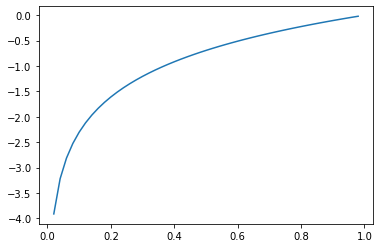

In [12]:
y = np.arange(0, 1, 0.02)
x = np.arange(0, 1, 0.02)
logy = np.log(y)

plt.plot(x, logy)
plt.show()

위와 같이 CEE는 입력 값이 1에 가까울 수록 Error 값이 작아지도록 설계되어있다.
여기서 입력 값은 Softmax 출력 값으로 정규화 되어있어 0 ~ 1 사이의 값들이다.

## Softmax-with-Loss 계층의 계산 그래프

먼저 Cross Entropy Error 층의 역전파를 계산한다. 이 과정은 비교적 쉽게 계산된다.

1. 곱셈 / 덧셈 / 곱셈 계층의 순서대로 계산을 하면 $t_1, t_2, t_3$이 나온다.
2. $\log x$ 대해서 미분 값은 $\frac{1}{x}$ 이므로 $t_1$에 대하여 $\log$ 계층의 역전파 값은 $-\frac{t_1}{y_1}$이 된다.

다음으로 Softmax 계층으로 역전파를 이어나가면 보다 복잡해진다.

0. ⭕ 먼저 순전파 때, 출력값이 여러 계층에 입력이 된다면 반대로 역전파 때는 이 출력값들의 합에 대하여 미분을 계산하여야 한다. ⭕
1. 첫번째 역전파 계층인 곱셈 계층의 역전파 출력값으로 $-\frac{t_1}{y_1} ⋅ \exp(a_1) = -{t_1}\frac{\exp(a_1)}{\exp(a_1)}{S} = -{t_1}S$ 과 $-\frac{t_1}{y_1} ⋅ \frac{1}{S} = -\frac{t_1}{\exp(a_1)}$ 이 나오게된다.
2. 먼저 앞의 값인 $-t_1S$ 에 대해서 다음 노드인 '/' 노드를 계산하면 $\frac{dy}{dS} = -\frac{1}{S^2}$이 되며, 순전파 때 3개의 갈래로 나뉘어 흘러갔던 값들을 다 더해주면 ($-t_1S -t_2S -t_3S)\cdot -\frac{1}{S^2}$ = $\frac{1}{S}(t_1+t_2+t_3)$이 된다.

- 여기서 (t_1, t_2, t_3)는 '원-핫 벡터'이며 이는 이 값들 중 단 하나만 1이고 나머지는 전부 0이다. 따라서 (t_1+t_2+t_3) = 1 이 된다.

3. $\frac{1}{S}(t_1+t_2+t_3) = \frac{1}{S}$, 다음 노드인 '+'노드는 역전파 시 입출력이 같기 때문에 그대로의 값을 내보낸다.

4. 다음으로 '$\exp$'노드에 대해서 풀게 되면 먼저 구한 $-\frac{t_1}{\exp(a_1)}$와 $\frac{1}{S}$이 입력값으로 들어가게 된다.

5. '$\exp$' 노드의 미분 값은 $\exp(a_1)$이 되며, 이 노드의 역전파 값은 $(-\frac{t_1}{\exp(a_1)} + \frac{1}{S}) \cdot \exp(a_1)$ = $
\frac{\exp(a_1)}{S}-t_1 = y_1 - t_1$


**이 두 계층의 역전파 값으로 $y_1 - t_1$라는 아주 깔끔한 값이 나오게 된다.**



In [13]:
# 계층 구현 코드

class SoftmaxWithLoss():
  def __init__(self):
    self.loss  = None #손실
    self.y = None     #softmax 출력
    self.t = None     #정답 레이블 (원 핫 벡터)

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx

In [14]:
x = np.array([[2, 8, 10, 4], [1, 3, 6, 1]])
t = np.array([[0,0,1,0],[0,0,1,0]])

A = SoftmaxWithLoss()
a = A.forward(x, t)

y = np.array([[0.1, 0.2 ,10, 1], [-0.1, 0.5, 20, -0.2]])
B = SoftmaxWithLoss()
b = B.forward(y, t)
print(a)
print(A.backward())

print(b)
print(B.backward())

0.095372961192538
[[ 0.00014737  0.05945409 -0.0606904   0.00108894]
 [ 0.00316852  0.0234124  -0.02974944  0.00316852]]
0.00011440839436362912
[[ 2.50815964e-05  2.77194510e-05 -1.14491820e-04  6.16907726e-05]
 [ 9.32504454e-10  1.69913390e-09 -3.47540330e-09  8.43764923e-10]]


In [15]:
# A와 B의 역전파 값 비교
print('A 오차 합 : ', np.sum(A.backward(), axis=1))
print('B 오차 합 : ', np.sum(B.backward(), axis=1))

A 오차 합 :  [2.64545330e-17 2.94902991e-17]
B 오차 합 :  [ 2.04914211e-17 -2.31843991e-17]


In [16]:
print(A.backward())

[[ 0.00014737  0.05945409 -0.0606904   0.00108894]
 [ 0.00316852  0.0234124  -0.02974944  0.00316852]]


In [17]:
d = A.backward()
print(d)
type(d)

[[ 0.00014737  0.05945409 -0.0606904   0.00108894]
 [ 0.00316852  0.0234124  -0.02974944  0.00316852]]


numpy.ndarray

In [18]:
np.sum(d, axis = 1)

array([2.64545330e-17, 2.94902991e-17])